# Homework: Implement a Mixture of Experts Model

## Overview

In this homework, you'll implement a Mixture of Experts (MoE) model for classifying points generated from two Gaussian distributions.

Please submit your Jupyter Notebook with all the completed tasks and questions answered.

In [105]:
# Import Libraries

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [106]:
# Generate the Dataset
def generate_data(n_samples=2000):
  X = torch.zeros(n_samples, 2)
  y = torch.zeros(n_samples, dtype=torch.long)

  # Generate samples from two Gaussian distributions
  X[:n_samples//2] = torch.randn(n_samples//2, 2) + torch.Tensor([3,2])
  X[n_samples//2:] = torch.randn(n_samples//2, 2) + torch.Tensor([-3,2])

  # Labels
  for i in range(X.shape[0]):
    if X[i].norm() > math.sqrt(13):
      y[i] = 1

  X[:, 1] = X[:, 1] - 2

  return X, y

data, labels = generate_data()

Question: Plot the generated dataset. Do you think a linear model would be able to separate the classes well?
# Visualize the data
# TODO

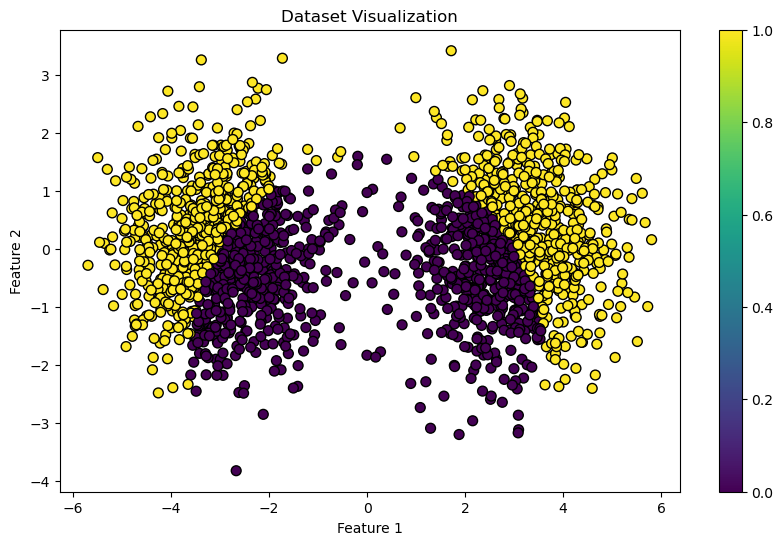

In [107]:
plt.figure(figsize=(10, 6))
plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Dataset Visualization')
plt.colorbar()  # Show class color scale
plt.show()

From the picture, I think a linear model would be able to separate the classes well.

## Expert Model

Task: Implement the Expert model. It should be a simple neural network with one linear layer.



In [108]:
class Expert(nn.Module):
  # TODO
  def __init__(self):
        super(Expert, self).__init__()
        self.linear = nn.Linear(2,1)
        
  def forward(self, x):
        x = self.linear(x)
        return x

## Gating Network

Task: Implement the Gating Network. It should output the probabilities for choosing each expert.

In [109]:
class GatingNetwork(nn.Module):
  # TODO
  #def __init__(self, num_experts):
  def __init__(self, num_experts):
        super(GatingNetwork, self).__init__()
        self.linear = nn.Linear(2, num_experts)
        self.num_experts = num_experts
        
  def forward(self, x):
        x = F.softmax(self.linear(x), dim=1)
        return x

## Mixture of Experts

Task: Implement the Mixture of Experts model. This model should utilize the Expert and Gating Network models to make a final prediction.

In [110]:
class MixtureOfExperts(nn.Module):
  # TODO
    #def __init__(self, num_experts=2):

    def __init__(self, num_experts=2):
        super(MixtureOfExperts, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([Expert() for _ in range(num_experts)])
        self.gating_network = GatingNetwork(num_experts)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        g = self.gating_network(x)
        output = torch.zeros(x.shape[0], 1, device=x.device)  
        for i in range(self.num_experts):
            output += g[:, i].unsqueeze(1) * self.experts[i](x)
        output = self.sigmoid(output)  
        return output

## Training Loop

Task: Write a training loop to train the Mixture of Experts model. Use binary cross-entropy loss and an Adam optimizer. Also, implement a learning rate scheduler that decays the learning rate.

In [111]:
# Define the model, loss, and optimizer
model = MixtureOfExperts()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500)

# Convert data and labels to float tensors
data_tensor = data.float()
labels_tensor = labels.view(-1, 1).float()

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    # Forward pass
    # TODO
    output = model(data_tensor) 
    loss = criterion(output, labels_tensor)
    accuracy = ((output > 0.5) == labels_tensor).sum().item() / labels_tensor.shape[0]

    # Backward pass and optimization
    # TODO
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Decay the learning rate
    # TODO
    scheduler.step()
    

    # Print out the loss and accuracy
    if (epoch+1) % 50 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item():.4f}")
        print(f"Accuracy: {accuracy:.4f}")

Epoch: 50, Loss: 0.5329
Accuracy: 0.7270
Epoch: 100, Loss: 0.3091
Accuracy: 0.8760
Epoch: 150, Loss: 0.2244
Accuracy: 0.9185
Epoch: 200, Loss: 0.1962
Accuracy: 0.9270
Epoch: 250, Loss: 0.1821
Accuracy: 0.9310
Epoch: 300, Loss: 0.1735
Accuracy: 0.9330
Epoch: 350, Loss: 0.1676
Accuracy: 0.9345
Epoch: 400, Loss: 0.1630
Accuracy: 0.9370
Epoch: 450, Loss: 0.1593
Accuracy: 0.9380
Epoch: 500, Loss: 0.1560
Accuracy: 0.9405
Epoch: 550, Loss: 0.1557
Accuracy: 0.9405
Epoch: 600, Loss: 0.1553
Accuracy: 0.9405
Epoch: 650, Loss: 0.1550
Accuracy: 0.9405
Epoch: 700, Loss: 0.1546
Accuracy: 0.9400
Epoch: 750, Loss: 0.1543
Accuracy: 0.9400
Epoch: 800, Loss: 0.1539
Accuracy: 0.9400
Epoch: 850, Loss: 0.1536
Accuracy: 0.9400
Epoch: 900, Loss: 0.1532
Accuracy: 0.9405
Epoch: 950, Loss: 0.1528
Accuracy: 0.9405
Epoch: 1000, Loss: 0.1524
Accuracy: 0.9405
Epoch: 1050, Loss: 0.1523
Accuracy: 0.9405
Epoch: 1100, Loss: 0.1523
Accuracy: 0.9405
Epoch: 1150, Loss: 0.1523
Accuracy: 0.9405
Epoch: 1200, Loss: 0.1522
Accur

## Decision Boundaries
Task: Plot the decision boundaries of the two experts, the gating network and the final model

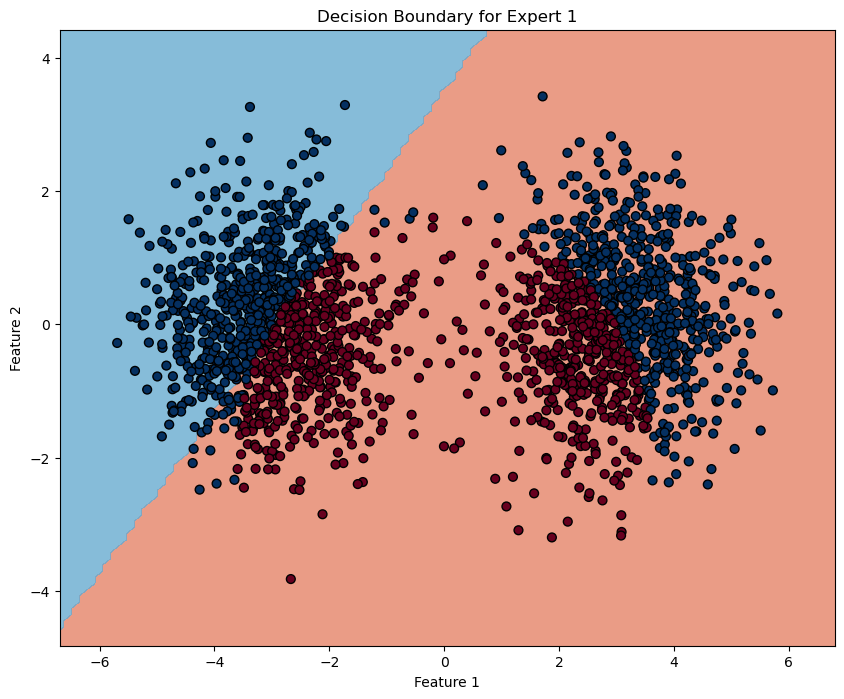

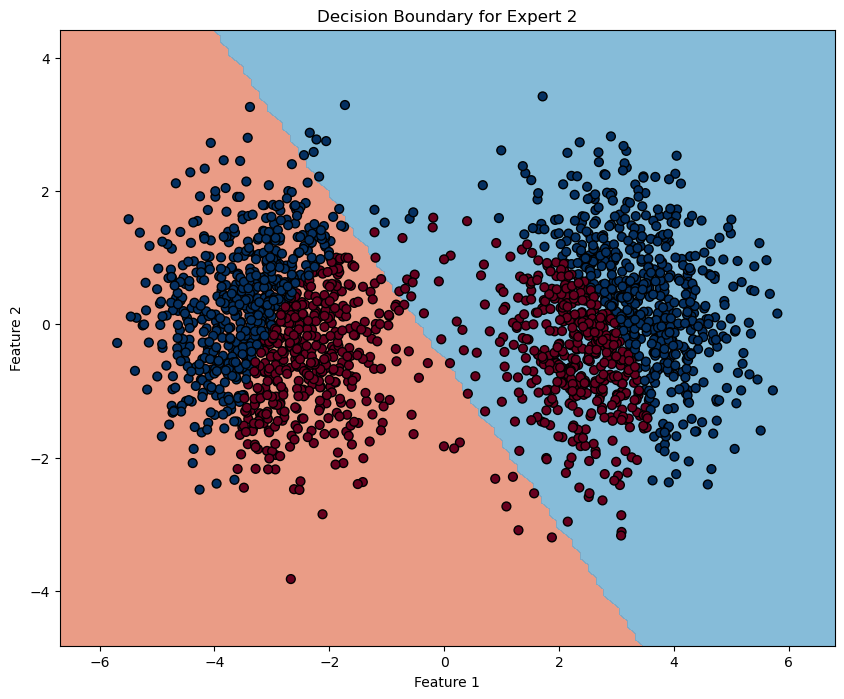

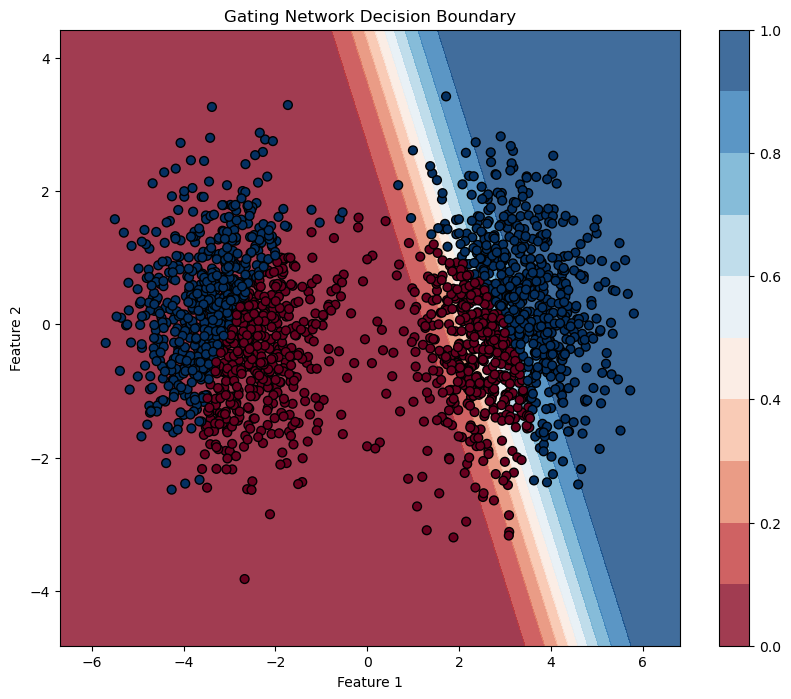

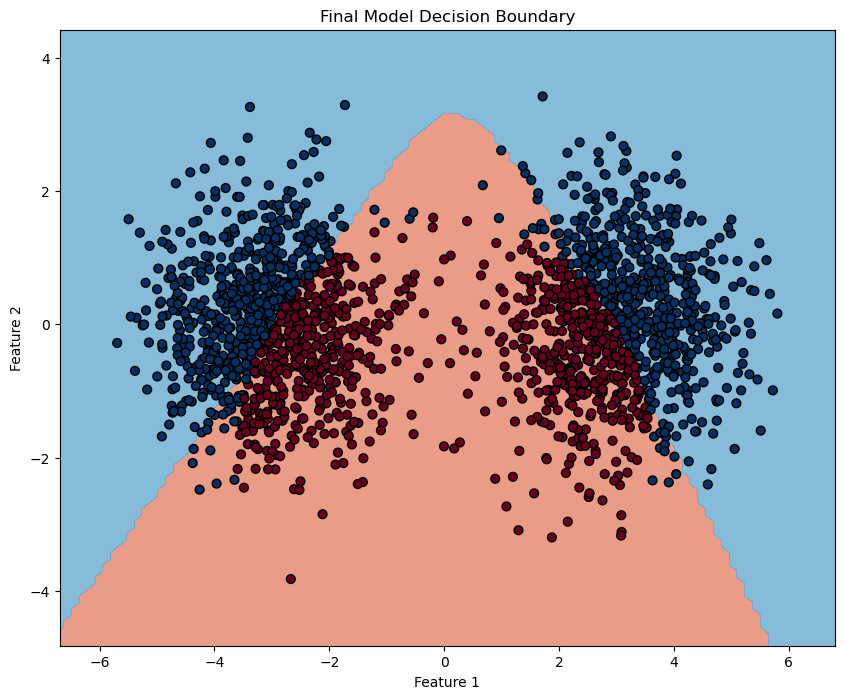

In [112]:
x_min, x_max = data_tensor[:, 0].min() - 1, data_tensor[:, 0].max() + 1
y_min, y_max = data_tensor[:, 1].min() - 1, data_tensor[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])

# Evaluate experts on the grid
expert_outputs = [expert(grid).detach().numpy() for expert in model.experts]

# Plot decision boundaries for each expert
for i, expert_output in enumerate(expert_outputs):
    plt.figure(figsize=(10, 8))
    Z_expert = expert_output.reshape(xx.shape)
    plt.contourf(xx, yy, Z_expert > 0.5, levels=[0, 0.5, 1], cmap='RdBu', alpha=0.8)
    plt.scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor[:, 0], s=40, cmap='RdBu', edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'Decision Boundary for Expert {i+1}')
    plt.show()

# Evaluate gating network on the grid
gating_output = model.gating_network(grid).detach().numpy()

# Plot the gating network's decision boundary
plt.figure(figsize=(10, 8))
Z_gating = gating_output[:, 1].reshape(xx.shape)
plt.contourf(xx, yy, Z_gating, levels=np.linspace(0, 1, 11), cmap='RdBu', alpha=0.8)
plt.colorbar()
plt.scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor[:, 0], s=40, cmap='RdBu', edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gating Network Decision Boundary')
plt.show()

# Combine expert outputs using the gating network's output as weights
combined_output = np.zeros_like(expert_outputs[0])
for i, expert_output in enumerate(expert_outputs):
    combined_output += gating_output[:, i].reshape(-1, 1) * expert_output

# Plot the final model's decision boundary
plt.figure(figsize=(10, 8))
Z_final = combined_output.reshape(xx.shape)
plt.contourf(xx, yy, Z_final > 0.5, levels=[0, 0.5, 1], cmap='RdBu', alpha=0.8)
plt.scatter(data_tensor[:, 0], data_tensor[:, 1], c=labels_tensor[:, 0], s=40, cmap='RdBu', edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Final Model Decision Boundary')
plt.show()


Question: Analyze the decision boundaries. What differences do you observe between the experts? How does the gating network decide between the two?


The two experts have different experts so that they result in different decision boundaries. From the picture shown above, expert 1 has a good performance when classifying the points in the left, while overlooking the points in the right. On the other hand, expert 2 has a bad performance as it seperates the points evenly. 
The gating network has its decision boundaries in the right side of the picture, which means it prefers expert 1 on the right side and expert 2 on the left side. 

## Bonus Task (2 points)
Try increasing the number of experts. How does the model complexity and decision boundary change? (You don't need to show your code for the new models, just plot the new decision boundaries and explain what did you find from the plots)

